In [65]:
import numpy as np
import json
import os
import glob
import random
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import models, transforms

In [36]:
np.random.seed(1234)
torch.manual_seed(1234)
random.seed(1234)

In [37]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0
Torchvision Version:  0.11.1


## Preprocessing

In [38]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
            transforms.RandomResizedCrop(
            resize, scale=(0.5, 1,0)
            ),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]),
            'val': transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, image, phase='train'):
        return self.data_transform[phase](image)

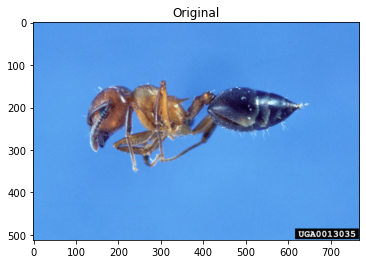

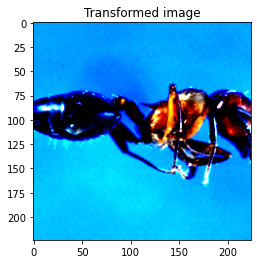

In [39]:
image_path = './hymenoptera_data/train/ants/0013035.jpg'
img = Image.open(image_path) #(height, weight, channel)

plt.imshow(img)
plt.title('Original')
plt.show()

size=224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img) #(channel, height, weight)

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.title('Transformed image')
plt.show()

## File Path

In [40]:
def make_data_path_list(phase='train'):
    root_path = './hymenoptera_data/'
    target_path = os.path.join(root_path+phase+'/**/*.jpg')
    print(target_path)

    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

In [41]:
train_list = make_data_path_list(phase='train')
val_list = make_data_path_list(phase='val')

./hymenoptera_data/train/**/*.jpg
./hymenoptera_data/val/**/*.jpg


## Dataset

In [42]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img, self.phase)

        if self.phase == 'train': label = img_path[25:29]
        elif self.phase == 'val' : label = img_path[23:27]

        if label == 'ants': label=0
        elif label == 'bees': label=1   

        return img_transformed, label

         

In [43]:
train_dataset = HymenopteraDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(val_dataset.__getitem__(index)[0].size())

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


## DataLoader

In [56]:
batch_size = 32
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iter = iter(dataloader_dict['train'])
input, label = next(batch_iter)
print(input.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0])


## Model

In [45]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Loss Function

In [47]:
loss = nn.CrossEntropyLoss()

## Optimization

In [48]:
params_to_update = []

update_param_name = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_param_name: 
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else: param.requires_grad = False

print("____________________")
print(params_to_update)

classifier.6.weight
classifier.6.bias
____________________
[Parameter containing:
tensor([[-0.0056,  0.0003, -0.0147,  ...,  0.0155, -0.0004, -0.0019],
        [-0.0098,  0.0003, -0.0043,  ...,  0.0097, -0.0123,  0.0027]],
       requires_grad=True), Parameter containing:
tensor([-0.0058,  0.0037], requires_grad=True)]


In [49]:
optimizer = optim.SGD(params=params_to_update, lr=0.01, momentum=0.9)

## train

In [66]:
def train_model(net, dataloader_dict, criterion, optimizer, epochs):
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("------------")

        for phase in ['train', 'val']:
            if phase == 'train': net.train()
            else: net.eval()

            epoch_loss = 0
            epoch_correct = 0

            if (epoch==0) and (phase=='train'): continue

            for inputs, labels in tqdm(dataloader_dict[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_correct += torch.sum(preds == labels.data)
                
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_correct.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} ACC: {:.4f}'.format(epoch, epoch_loss, epoch_acc))



In [67]:
num_epochs = 2
train_model(net, dataloader_dict, loss, optimizer, num_epochs)  

Epoch 1/2
------------


100%|██████████| 5/5 [01:27<00:00, 17.49s/it]


0 Loss: 0.7258 ACC: 0.4510
Epoch 2/2
------------


100%|██████████| 8/8 [02:08<00:00, 16.10s/it]


1 Loss: 0.2838 ACC: 0.8765


100%|██████████| 5/5 [01:20<00:00, 16.06s/it]

1 Loss: 0.2106 ACC: 0.9150
